In [205]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [206]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2
import matplotlib.pyplot as plt
import os

In [207]:
import sys
sys.path.append("py")

import w8_estimation as est 
import w8_LinearModel as lm
import w8_probit as probit
import w8_logit as logit


## Read data and preliminary data selection

In [208]:
data = pd.read_csv('ppcs_cc.csv')

assert data.notnull().all().all()

print(f'All years are the same: \t{(data['year'] == 2011).all()}') # all variables are for the same year -> drop year as feature

print(f'Dummy trap in officer race: \t{data['omajother'].sum() + data['omajwhite'].sum() + data['omajhisp'].sum() + data['omajblack'].sum() == len(data)}')  # one-hot encoded -> drop one category to avoid multicollinearity

print(f'Dummy trap in civilian race: \t{data['sother'].sum() + data['swhite'].sum() + data['shisp'].sum() + data['sblack'].sum() == len(data)}')  # one-hot encoded -> drop one category to avoid multicollinearity

print(f'osplit is 0 for all obs: \t{data['osplit'].sum() == 0}')  # no variation -> drop feature

All years are the same: 	True
Dummy trap in officer race: 	True
Dummy trap in civilian race: 	True
osplit is 0 for all obs: 	True


In [209]:
pd.DataFrame({
    "mean": data.mean(),
    "sum": data.sum()
    }).round(2)

,mean,sum
sblack,0.11,420
shisp,0.10,386
swhite,0.74,2808
sother,0.05,185
smale,0.53,2012
sage,41.01,155797
sempl,0.70,2642
sincome,2.16,8224
spop,1.36,5177
daytime,0.67,2532


## Data selection

In [210]:
# types of features
x_labels = ['sblack', # dummy
 'shisp', # dummy
 #'swhite', # dummy -> dropped because of dummy trap: see earlier
 'sother', # dummy 
 'smale', # dummy
 'sage', # continuous / categorical
 'sempl', # dummy
 'sincome', # categorical with numerical interpretation 
 'spop', # categorical with numerical interpretation 
 'daytime', # categorical, non-numerical interpretation
 'inctype_lin', # categorical / dummy?
 #'omajblack', # dummy -> collaped with omajhisp for union dummy to avoid seperation
 #'omajhisp', # dummy -> collaped with omajblack for union dummy to avoid seperation
 'omajwhite', # dummy
 #'omajother', # dummy -> dropped because of dummy trap: see earlier
 #'osplit', # invariant -> dropped
 #'year' # invariant -> dropped
 'sbehavior', # dummy
 ]

x_labels_imp = ['sblack', 'shisp', 'sother', 'smale', 'daytime', 'omajwhite', 'sbehavior']

data['omajblackhisp'] = data['omajblack'] + data['omajhisp']
x_labels += ['omajblackhisp']

y_label = 'anyuseofforce_coded'

# list of variables to scale or square
scales = ['sage']
squares = []

# square
for var in squares:
    sq_label = var + 'sq'
    data[sq_label] = data[var]**2
    x_labels += [sq_label]

# scale
for var in scales:
    #data[var] = (data[var] - data[var].mean())/data[var].std() # standardization
    data[var] = data[var]/10 # divide by 10 scaling

In [211]:
y = data[y_label]
x = data[x_labels]

In [212]:
y = y.values
x = x.values

In [213]:
assert np.linalg.matrix_rank(x.T @ x) == x.shape[1]  # check for multicollinearity

## Intensive margin: Events with force

In [214]:
data[x_labels][data['anyuseofforce_coded'] == 1]

,sblack,shisp,sother,smale,sage,sempl,sincome,spop,daytime,inctype_lin,omajwhite,sbehavior,omajblackhisp
6,1,0,0,1,2.8,0,1,4,1,1,1,1,0
70,0,1,0,1,3.0,1,1,4,0,2,1,1,0
354,1,0,0,1,4.0,0,3,2,1,2,1,0,0
419,0,0,0,1,2.3,1,1,2,1,2,1,1,0
1011,0,0,0,1,2.0,1,3,1,1,2,1,1,0
1091,0,0,0,1,3.4,0,1,1,0,2,1,1,0
1834,0,1,0,1,2.2,0,3,3,0,2,1,0,0
1958,0,1,0,1,4.0,1,1,1,1,1,1,0,0
2156,0,1,0,0,2.6,0,2,4,1,1,0,1,1
2558,1,0,0,1,3.2,1,2,1,1,1,1,0,0


## Intensive vs. Extensive margin for sage, sincome, spop, inctype_lin, sempl

Variables which are primarly included as controls, which means we will likely average them out later

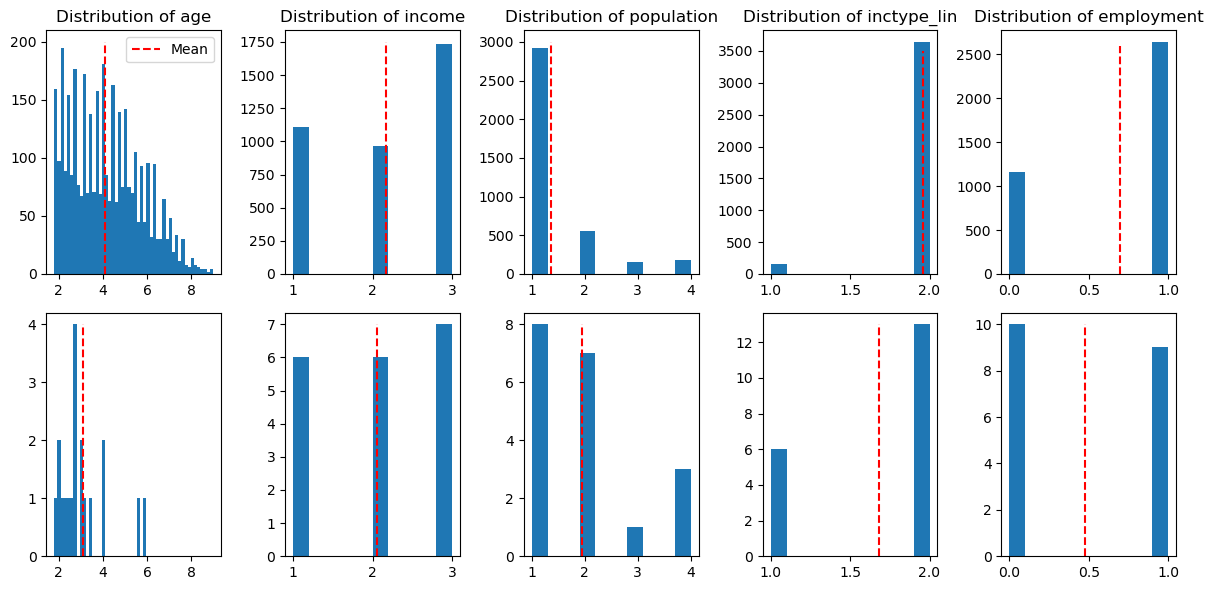

In [215]:
f, ax = plt.subplots(2, 5, figsize=(12, 6))

# extensive margin
ax[0,0].set_title('Distribution of age')
ax[0,0].hist(data['sage'], bins=50, range=[1.8, 9.0])
ax[0,0].vlines(data['sage'].mean(), 0, 200, colors='r', linestyles='dashed', label='Mean') # mean and median overlaps
ax[0,0].legend()

ax[0,1].set_title('Distribution of income')
ax[0,1].hist(data['sincome'])
ax[0,1].vlines(data['sincome'].mean(), 0, 1750, colors='r', linestyles='dashed')

ax[0,2].set_title('Distribution of population')
ax[0,2].hist(data['spop'])
ax[0,2].vlines(data['spop'].mean(), 0, 3000, colors='r', linestyles='dashed')

ax[0,3].set_title('Distribution of inctype_lin')
ax[0,3].hist(data['inctype_lin'])
ax[0,3].vlines(data['inctype_lin'].mean(), 0, 3500, colors='r', linestyles='dashed')

ax[0,4].set_title('Distribution of employment')
ax[0,4].hist(data['sempl'])
ax[0,4].vlines(data['sempl'].mean(), 0, 2600, colors='r', linestyles='dashed')

# intensive margin
ax[1,0].hist(data['sage'][data['anyuseofforce_coded'] == 1], bins=50, range=[1.8, 9.0])
ax[1,0].vlines(data['sage'][data['anyuseofforce_coded'] == 1].mean(), 0, 4, colors='r', linestyles='dashed')

ax[1,1].hist(data['sincome'][data['anyuseofforce_coded'] == 1])
ax[1,1].vlines(data['sincome'][data['anyuseofforce_coded'] == 1].mean(), 0, 7, colors='r', linestyles='dashed')

ax[1,2].hist(data['spop'][data['anyuseofforce_coded'] == 1])
ax[1,2].vlines(data['spop'][data['anyuseofforce_coded'] == 1].mean(), 0, 8, colors='r', linestyles='dashed')

ax[1,3].hist(data['inctype_lin'][data['anyuseofforce_coded'] == 1])
ax[1,3].vlines(data['inctype_lin'][data['anyuseofforce_coded'] == 1].mean(), 0, 13, colors='r', linestyles='dashed')

ax[1,4].hist(data['sempl'][data['anyuseofforce_coded'] == 1])
ax[1,4].vlines(data['sempl'][data['anyuseofforce_coded'] == 1].mean(), 0, 10, colors='r', linestyles='dashed')

f.tight_layout()
f.savefig('IntensivevsExtensiveMargin.png')

In [216]:
print(f'Intensive margin averages:')
print(f'sage:\t\t{data['sage'].mean():.2f}')
print(f'sincome:\t{data['sincome'].mean():.2f}')
print(f'spop:\t\t{data['spop'].mean():.2f}')
print(f'inctype_lin:\t{data['inctype_lin'].mean():.2f}')
print(f'sempl:\t\t{data['sempl'].mean():.2f}')

Intensive margin averages:
sage:		4.10
sincome:	2.16
spop:		1.36
inctype_lin:	1.96
sempl:		0.70


## Linear Probability Model (LPM)

In [217]:
ols_results =  lm.estimate(y, x, robust_se=True)
ols_tab = lm.print_table((y_label, x_labels), ols_results, title='LPM results')
ols_tab

LPM results
Dependent variable: anyuseofforce_coded

R2 = 0.030
sigma2 = nan


,b_hat,se,t
sblack,0.0027,0.0047,0.5776
shisp,0.0098,0.0061,1.6159
sother,0.0010,0.0058,0.1773
smale,0.0048,0.0022,2.1640
sage,-0.0012,0.0006,-2.0251
sempl,-0.0052,0.0032,-1.6432
sincome,0.0017,0.0014,1.2437
spop,0.0050,0.0022,2.2632
daytime,-0.0016,0.0029,-0.5700
inctype_lin,-0.0158,0.0085,-1.8586


In [218]:
for alpha in [0.01, 0.05, 0.1]:
    print(f'{alpha} level of significance bears the critical value {norm.ppf(1-alpha/2):.2f}')

0.01 level of significance bears the critical value 2.58
0.05 level of significance bears the critical value 1.96
0.1 level of significance bears the critical value 1.64


## Probit

In [219]:
theta0 = probit.starting_values(y, x)
print(theta0)

[ 0.00676642  0.024479    0.00257739  0.01208594 -0.00308831 -0.01295327
  0.00428799  0.01239178 -0.0040811  -0.03952321  0.07367845  0.09078797
  0.06193903]


In [220]:
ll = probit.loglikelihood(theta0, y, x)
ll

array([-0.70965743, -0.73591667, -0.72179857, ..., -0.68027293,
       -0.71621508, -0.68389996])

In [221]:
probit_results = est.estimate(probit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023229
         Iterations: 84
         Function evaluations: 1288
         Gradient evaluations: 92


In [222]:
probit_tab = est.print_table(x_labels, probit_results, title=f'Logit, y = {y_label}')
probit_tab

Optimizer succeeded after 84 iter. (1288 func. evals.). Final criterion:  0.02323.
Logit, y = anyuseofforce_coded


,theta,se,t
sblack,0.1386,0.3640,0.3807
shisp,0.3509,0.3034,1.1567
sother,-0.0187,0.6173,-0.0304
smale,0.4747,0.3768,1.2600
sage,-0.1596,0.1643,-0.9714
sempl,-0.4436,0.2588,-1.7143
sincome,0.0133,0.1725,0.0774
spop,0.1738,0.1685,1.0316
daytime,-0.1501,0.3095,-0.4849
inctype_lin,-0.9302,0.3263,-2.8504


## Logit

In [223]:
theta0 = logit.starting_values(y, x)
theta0

array([ 0.01082627,  0.03916641,  0.00412382,  0.01933751, -0.0049413 ,
       -0.02072522,  0.00686078,  0.01982685, -0.00652976, -0.06323714,
        0.11788551,  0.14526076,  0.09910245])

In [224]:
logit_results = est.estimate(logit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023193
         Iterations: 117
         Function evaluations: 1666
         Gradient evaluations: 119


In [225]:
logit_tab = est.print_table(x_labels, logit_results, title=f'Logit, y = {y_label}')
logit_tab

Optimizer succeeded after 117 iter. (1666 func. evals.). Final criterion:  0.02319.
Logit, y = anyuseofforce_coded


,theta,se,t
sblack,0.1596,0.9056,0.1762
shisp,0.7646,0.6804,1.1238
sother,-0.4407,1.5605,-0.2824
smale,1.0148,0.8116,1.2504
sage,-0.4230,0.3823,-1.1064
sempl,-1.0148,0.5792,-1.7521
sincome,0.0033,0.3755,0.0089
spop,0.4923,0.3618,1.3604
daytime,-0.4092,0.7090,-0.5771
inctype_lin,-1.8597,0.7243,-2.5677


## Partial effects: Functions

In [226]:
def current_and_next_value(df, var, value):

    # get unique values and sort
    uniques = np.sort(df[var].unique())
    if (uniques[0] == 0 and uniques[1] == 1):
        dummy_var = True

    else:
        dummy_var = False

    # assert value is in range
    if value < uniques[0] or value > uniques[-1]:
        raise ValueError(f'Value {value} is out of range [{uniques[0]}, {uniques[-1]})')
    
    if dummy_var:
        return 0, 1
    
    else:
        
        # find index of value and next value by going through list of uniques and flooring
        for i, i_v in enumerate(uniques):

            if i_v == value:
                indx = i
                break

            if i_v > value:
                indx = i - 1
                break

        indx_next = indx + 1

        return uniques[indx], uniques[indx_next]

def compute_simple_pe(x_old, x_new, theta_probit, theta_logit, compute_grads=False):

    # probit
    pe_probit = probit.predict(theta_probit, x_new) - probit.predict(theta_probit, x_old)

    # logit
    pe_logit = logit.predict(theta_logit, x_new) - logit.predict(theta_logit, x_old)

    if not compute_grads:
        return np.array([pe_probit, pe_logit])

    else:
        g_probit = norm.pdf(x_new * theta_probit)*x_new - norm.pdf(x_old * theta_probit)*x_new
        g_logit = logit.predict(theta_logit, x_new)*(1-logit.predict(theta_logit, x_new))*x_new - logit.predict(theta_logit, x_old)*(1 - logit.predict(theta_logit, x_old))*x_old
        return np.array([pe_probit, pe_logit]), np.array([g_probit, g_logit])

## Average Partial Effects (APE)

In [227]:
b_lpm = ols_tab.b_hat.values
b_probit = probit_tab.theta.values
b_logit = logit_tab.theta.values

pes = np.zeros((len(x_labels_imp), x.shape[0], 3)) + np.nan 

for i, var in enumerate(x_labels_imp):

    idx = x_labels.index(var)

    pes_i = np.zeros((x.shape[0], 3)) + np.nan # logit, probit

    for obs in range(x.shape[0]):

        x_obs = x[obs]
        
        x_obs_high = x_obs.copy()
        x_obs_low = x_obs.copy()

        x_obs_low[idx], x_obs_high[idx] = current_and_next_value(data, var, x_obs[idx])

        pes_i[obs, :2] = compute_simple_pe(x_obs_low, x_obs_high, b_probit, b_logit)
        pes_i[obs, -1] = lm.predict(b_lpm, x_obs_high) - lm.predict(b_lpm, x_obs_low)
    
    pes[i, :, :] = pes_i

In [228]:
APE = pes.mean(axis=1)

In [229]:
for i, var in enumerate(x_labels_imp): print(f'{var} has same APE and LPM:\t{np.isclose(b_lpm[x_labels.index(var)], APE[i, -1])}')

sblack has same APE and LPM:	True
shisp has same APE and LPM:	True
sother has same APE and LPM:	True
smale has same APE and LPM:	True
daytime has same APE and LPM:	True
omajwhite has same APE and LPM:	True
sbehavior has same APE and LPM:	True


In [230]:
APE_df = pd.DataFrame(APE, columns = ['Probit', 'Logit', 'LPM'], index=x_labels_imp)

APE_df

,Probit,Logit,LPM
sblack,0.001780,0.000781,0.0027
shisp,0.005152,0.004376,0.0098
sother,-0.000213,-0.001751,0.0010
smale,0.004876,0.004227,0.0048
daytime,-0.001761,-0.001917,-0.0016
omajwhite,-0.021188,-0.015205,0.0295
sbehavior,0.026403,0.025967,0.0363


## Partial Effects on the Average (PEA)

##

In [231]:
def compute_all_pe(x_, x_labels, b_probit, b_logit, cov_probit, cov_logit, do_delta=True):

    pea = np.zeros((x_.shape[0], 2)) # one col for probit, one for logit
    pea_se = np.zeros((x_.shape[0], 2))

    for i, var in enumerate(x_labels):

        idx = x_labels.index(var)
        x_low = x_.copy()
        x_high = x_.copy()

        x_low[idx], x_high[idx] = current_and_next_value(data, var, x_[idx])
        pea[i,:], gs = compute_simple_pe(x_low, x_high, b_probit, b_logit, compute_grads=True)

        if do_delta:

            # probit
            g_probit = gs[0]
            se_probit = np.sqrt(g_probit.T @ cov_probit @ g_probit)

            # logit
            g_logit = gs[1]
            se_logit = np.sqrt(g_logit.T @ cov_logit @ g_logit)

            pea_se[i,:] =  np.array([se_probit, se_logit])

        else:
            pea_se[i,:] = np.array([np.nan, np.nan]) # nan out
    
    return pea, pea_se

In [232]:
b_lpm = ols_tab.b_hat.values
b_probit = probit_tab.theta.values
b_logit = logit_tab.theta.values

cov_lpm = ols_results.get('cov')
cov_probit = probit_results.get('cov')
cov_logit = logit_results.get('cov')

In [233]:
average_joe = x.mean(axis=0)
average_joe_intensive = x[y == 1].mean(axis=0)

pea, se_pea_delta = compute_all_pe(average_joe, x_labels, b_probit, b_logit, cov_probit, cov_logit, do_delta=True)

pea_intensive, se_pea_intensive_delta = compute_all_pe(average_joe_intensive, x_labels, b_probit, b_logit, cov_probit, cov_logit, do_delta=True)

In [234]:
pea_df = pd.DataFrame(pea,
                      columns=['Probit', 'Logit'],
                      index=x_labels)

pea_df

,Probit,Logit
sblack,0.000491,0.000220
shisp,0.001669,0.001372
sother,-0.000054,-0.000471
smale,0.001467,0.001328
sage,-0.000046,-0.000054
sempl,-0.001844,-0.001668
sincome,0.000040,0.000004
spop,0.000564,0.000688
daytime,-0.000487,-0.000570
inctype_lin,-0.011838,-0.006447


In [267]:
pea_intensive_df = pd.DataFrame(pea_intensive,
                      columns=['Probit', 'Logit'],
                      index=x_labels)

pea_intensive_df

,Probit,Logit
sblack,0.012010,0.004733
shisp,0.031599,0.025043
sother,-0.001465,-0.010362
smale,0.029969,0.022423
sage,-0.001280,-0.001204
sempl,-0.035187,-0.028854
sincome,0.001069,0.000093
spop,0.012024,0.011344
daytime,-0.011879,-0.011467
inctype_lin,-0.104816,-0.079972


## Specific Partial Effects of Interest

In [236]:
for col in data.columns:
    if col in x_labels:
        print(f'{col}:  {data[col].unique()}')

sblack:  [1 0]
shisp:  [0 1]
sother:  [0 1]
smale:  [1 0]
sage:  [1.8 2.  2.2 2.9 2.8 2.6 2.5 3.  4.1 4.4 4.7 4.8 5.2 1.6 1.7 1.9 2.1 2.4
 2.3 2.7 3.1 3.2 3.3 3.4 3.5 3.9 3.7 3.6 4.  4.3 4.2 4.6 4.5 5.3 5.  5.1
 5.4 5.9 5.7 5.8 5.5 5.6 6.1 6.  6.3 6.4 6.2 6.9 6.8 6.6 7.1 7.2 9.  7.8
 8.3 3.8 4.9 6.5 7.  7.3 7.4 8.5 7.7 8.1 8.  7.6 6.7 7.9 8.6 7.5 8.4 8.2
 8.8 8.9]
sempl:  [0 1]
sincome:  [1 2 3]
spop:  [1 4 3 2]
daytime:  [1 0]
inctype_lin:  [2 1]
omajwhite:  [1 0]
sbehavior:  [0 1]
omajblackhisp:  [0 1]


General decisions:

$\texttt{omajblackhisp}=0$

$\texttt{omajwhite}=1$

$\texttt{sage}=4.10$

$\texttt{sincome}=2.16$

$\texttt{pop}=1.36$

$\texttt{inctype\_lin}=1.96$

$\texttt{sempl}=0.7$

In [237]:
special_joe = np.array([np.nan, # sblack
                        np.nan, # shisp
                        np.nan, # swhite
                        np.nan, # smale
                        4.10, # sage
                        0.70, # sempl
                        2.16, # sincome
                        1.36, # spop
                        np.nan, # daytime
                        1.96, # inctype_lin
                        1.0, # omajwhite
                        np.nan, # sbehavior
                        0.0 # omajblackhisp
                        ])

In [238]:
def compute_special_pes(spec_joe, b_probit, b_logit):
    results = np.zeros((8,3,2)) + np.nan
    grads = np.zeros((8,3,3)) + np.nan

    # outer loop over specifications: 2^3 = 8
    i = 0 # counter
    for smale in [0, 1]:
        for daytime in [0, 1]:
            for sbehavior in [0, 1]:

                special_joe_i = spec_joe.copy()

                special_joe_i[x_labels.index('smale')] = smale
                special_joe_i[x_labels.index('daytime')] = daytime
                special_joe_i[x_labels.index('sbehavior')] = sbehavior

                # inner loop over races: 3 -> #operations = 8*3 = 24

                # 1st case: white to black
                joe_1st_pre = special_joe_i.copy()
                joe_1st_post = special_joe_i.copy()

                joe_1st_pre[x_labels.index('shisp')], joe_1st_post[x_labels.index('shisp')] = 0,0
                joe_1st_pre[x_labels.index('sother')], joe_1st_post[x_labels.index('sother')] = 0,0

                joe_1st_pre[x_labels.index('sblack')] = 0.0
                joe_1st_post[x_labels.index('sblack')] = 1.0

                results[i,0,:] = compute_simple_pe(joe_1st_pre, joe_1st_post, b_probit, b_logit)

                # 2nd case: white to hisp
                joe_2nd_pre = special_joe_i.copy()
                joe_2nd_post = special_joe_i.copy()

                joe_2nd_pre[x_labels.index('sblack')], joe_2nd_post[x_labels.index('sblack')] = 0,0
                joe_2nd_pre[x_labels.index('sother')], joe_2nd_post[x_labels.index('sother')] = 0,0

                joe_2nd_pre[x_labels.index('shisp')] = 0.0
                joe_2nd_post[x_labels.index('shisp')] = 1.0

                results[i,1,:] = compute_simple_pe(joe_2nd_pre, joe_2nd_post, b_probit, b_logit)

                # 3rd case: white to other
                joe_3rd_pre = special_joe_i.copy()
                joe_3rd_post = special_joe_i.copy()

                joe_3rd_pre[x_labels.index('shisp')], joe_3rd_post[x_labels.index('shisp')] = 0,0
                joe_3rd_pre[x_labels.index('sblack')], joe_3rd_post[x_labels.index('sblack')] = 0,0

                joe_3rd_pre[x_labels.index('sother')] = 0.0
                joe_3rd_post[x_labels.index('sother')] = 1.0

                results[i,2,:] = compute_simple_pe(joe_3rd_pre, joe_3rd_post, b_probit, b_logit)

                # update counter
                i += 1

    return results

In [239]:
def print_cases(*args):
    i = 0
    for smale in [0, 1]:
        for daytime in [0, 1]:
            for sbehavior in [0, 1]:
                print(f'row {i}:\t\tsmale={smale}, daytime={daytime}, sbehavior={sbehavior}',*args)
                i += 1

print_cases()

row 0:		smale=0, daytime=0, sbehavior=0
row 1:		smale=0, daytime=0, sbehavior=1
row 2:		smale=0, daytime=1, sbehavior=0
row 3:		smale=0, daytime=1, sbehavior=1
row 4:		smale=1, daytime=0, sbehavior=0
row 5:		smale=1, daytime=0, sbehavior=1
row 6:		smale=1, daytime=1, sbehavior=0
row 7:		smale=1, daytime=1, sbehavior=1


In [240]:
special_pes = compute_special_pes(special_joe, b_probit, b_logit)

## Bootstrapping

In [241]:
def bootstrap_sample(y, x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: 1-dimensional N-array
        x: (N,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: N-array
            x_i: (N,K) matrix 
    '''
    N = y.size

    ii_boot = np.random.choice(N, size=N, replace=True) # indices of the bootstrap sample

    y_i = y[ii_boot] # selection of N rows from y 
    x_i = x[ii_boot] # selection of N rows from x 
    
    return y_i, x_i 

In [242]:
generate_results = False

In [243]:
if generate_results:
    nboot = 1000  # Number of bootstraps, should ideally be very large 

    # Set seed for random sampling.
    seed = 42
    rng = np.random.seed(seed)

    # initialize 
    special_pes_boot = np.zeros((nboot, 8, 3, 2))
    pea_boot = np.zeros((nboot, x.shape[1], 2)) + np.nan # 2 models: probit, logit
    pea_intensive_boot = np.zeros((nboot, x.shape[1], 2)) + np.nan # 2 models: probit, logit

    b_probit_boot = np.zeros((nboot, x.shape[1])) + np.nan
    b_logit_boot = np.zeros((nboot, x.shape[1])) + np.nan
    b_lpm_boot = np.zeros((nboot, x.shape[1])) + np.nan

    for i in range(nboot): 

        print(f'Bootstrap iteration {i+1}/{nboot}')
        
        # 1. choose which individuals to draw
        y_i, x_i = bootstrap_sample(y, x)

        # 2. estimate and compute 
        ols_results =  lm.estimate(y_i, x_i, robust_se=True)

        theta0 = probit.starting_values(y_i, x_i)
        probit_results = est.estimate(probit.q, theta0, y_i, x_i, options={'disp': False}, cov_type=None)

        theta0 = logit.starting_values(y_i, x_i)
        logit_results = est.estimate(logit.q, theta0, y_i, x_i, options={'disp': False}, cov_type=None)

        # 2. save coefs
        b_probit_boot[i, :] = probit_results['theta']
        b_logit_boot[i, :] = logit_results['theta']
        b_lpm_boot[i, :] = ols_results['b_hat']

        # 3. compute pea and pea_intensive
        pea_boot[i, :, :], _ = compute_all_pe(average_joe, x_labels, probit_results['theta'], logit_results['theta'], None, None, do_delta=False)
        pea_intensive_boot[i, :, :], _ = compute_all_pe(average_joe_intensive, x_labels, probit_results['theta'], logit_results['theta'], None, None, do_delta=False)

        # 4. compute selected PEs
        special_pes_boot[i, :, :, :] = compute_special_pes(special_joe, probit_results['theta'], logit_results['theta'])  

In [244]:
folder = 'BS_results'

if generate_results:

    os.makedirs(folder, exist_ok=True)

    np.save(folder + '/b_lpm_boot', b_lpm_boot)
    np.save(folder + '/b_logit_boot', b_logit_boot)
    np.save(folder + '/b_probit_boot', b_probit_boot)

    np.save(folder + '/pea_boot', pea_boot)
    np.save(folder + '/pea_intensive_boot', pea_intensive_boot)
    np.save(folder + '/special_pes_boot', special_pes_boot)

else:

    b_lpm_boot = np.load(folder + '/b_lpm_boot.npy')
    b_probit_boot = np.load(folder + '/b_probit_boot.npy')
    b_logit_boot = np.load(folder + '/b_logit_boot.npy')
    
    pea_boot = np.load(folder + '/pea_boot.npy')
    special_pes_boot = np.load(folder + '/special_pes_boot.npy')

## Unpacking standard errors from bootstrapping

### Standard errors for LPM, Probit, Logit estimators

In [245]:
se_lpm_bs = b_lpm_boot.std(axis=0)
se_probit_bs = b_probit_boot.std(axis=0)
se_logit_bs = b_logit_boot.std(axis=0)

se_bs = pd.DataFrame(np.column_stack((se_lpm_bs, se_probit_bs, se_logit_bs)),
                     columns=['LPM', 'Probit', 'Logit'],
                     index=x_labels)

if generate_results:
    se_bs.to_csv(folder + '/se_boot.csv')

else:
    se_bs = pd.read_csv(folder + '/se_boot.csv', index_col=0)

se_bs

,LPM,Probit,Logit
sblack,0.004576,0.951934,2.032280
shisp,0.006287,0.357353,0.882289
sother,0.005964,2.212563,4.760584
smale,0.002246,0.220895,0.588940
sage,0.000634,0.088963,0.227214
sempl,0.003196,0.314416,0.755680
sincome,0.001381,0.129819,0.322686
spop,0.002104,0.098818,0.243349
daytime,0.002779,0.233428,0.589133
inctype_lin,0.008115,0.210813,0.578497


### Covariance matrices in LPM, Probit, Logit estimators

In [246]:
cov_lpm_bs = np.cov(b_lpm_boot, rowvar=False)
cov_probit_bs = np.cov(b_probit_boot, rowvar=False)
cov_logit_bs = np.cov(b_logit_boot, rowvar=False)

### Standard errors for PEA and special PE of interest

In [247]:
se_pea_bs = pea_boot.std(axis=0)
se_spe_bs = special_pes_boot.std(axis=0)

In [277]:
se_pea_intensive_bs = pea_intensive_boot.std(axis=0)

In [278]:
se_pea_bs_df = pd.DataFrame(se_pea_bs,
                            columns=['Probit', 'Logit'],
                            index=x_labels)

if generate_results:
    se_pea_bs_df.to_csv(folder + '/se_pea_boot.csv')

else:
    se_pea_bs_df = pd.read_csv(folder + '/se_pea_boot.csv', index_col=0)

se_pea_bs_df

,Probit,Logit
sblack,0.000911,0.000994
shisp,0.001285,0.001240
sother,0.001218,0.001077
smale,0.000698,0.000658
sage,0.000017,0.000018
sempl,0.001067,0.000985
sincome,0.000218,0.000245
spop,0.000247,0.000262
daytime,0.000433,0.000505
inctype_lin,0.006660,0.004554


In [279]:
se_spe_bs_probit = se_spe_bs[..., 0]
se_spe_bs_logit = se_spe_bs[..., 1]

se_spe_bs_probit_df = pd.DataFrame(se_spe_bs_probit,
                            columns=['White->Black', 'White->Hisp', 'White->Other'])

se_spe_bs_logit_df = pd.DataFrame(se_spe_bs_logit,
                            columns=['White->Black', 'White->Hisp', 'White->Other'])

if generate_results:
    se_spe_bs_probit_df.to_csv(folder + '/se_spe_bs_probit_df.csv')
    se_spe_bs_logit_df.to_csv(folder + '/se_spe_bs_logit_df.csv')

else:
    se_spe_bs_probit_df = pd.read_csv(folder + '/se_spe_bs_probit_df.csv', index_col=0)
    se_spe_bs_logit_df = pd.read_csv(folder + '/se_spe_bs_logit_df.csv', index_col=0)

In [280]:
se_spe_bs_probit_df

,White->Black,White->Hisp,White->Other
0,0.000619,0.001258,0.001156
1,0.011893,0.014838,0.014577
2,0.000413,0.000538,0.000434
3,0.008358,0.008481,0.008155
4,0.002579,0.004392,0.003492
5,0.028548,0.033058,0.033209
6,0.001959,0.002531,0.001929
7,0.022144,0.022720,0.023043


In [281]:
se_spe_bs_logit_df

,White->Black,White->Hisp,White->Other
0,0.000778,0.001241,0.001074
1,0.010323,0.012868,0.012442
2,0.000575,0.000664,0.000516
3,0.007041,0.006692,0.006115
4,0.002303,0.003721,0.002774
5,0.024722,0.033349,0.027988
6,0.001894,0.002311,0.001591
7,0.019042,0.020263,0.016394


### Covariance matrices in PEA

In [282]:
pea_boot_probit = pea_boot[..., 0]
pea_boot_logit = pea_boot[..., 1]

cov_pea_probit_bs = np.cov(pea_boot_probit, rowvar=False)
cov_pea_logit_bs = np.cov(pea_boot_logit, rowvar=False)

### Covariance matrices in Special PE of Interest

In [284]:
special_pes_boot_probit = special_pes_boot[..., 0]
special_pes_boot_logit = special_pes_boot[..., 1]

cov_special_boot_probit = np.zeros((8, 3, 3)) + np.nan
cov_special_boot_logit = np.zeros((8, 3, 3)) + np.nan

for i in range(8): cov_special_boot_probit[i, :, :] = np.cov(special_pes_boot_probit[:, i, :], rowvar=False)
for i in range(8): cov_special_boot_logit[i, :, :] = np.cov(special_pes_boot_logit[:, i, :], rowvar=False)

## t-test of PEA on delta standard errors

In [291]:
pea_t_values_delta = pea / se_pea_delta

pea_t_values_delta_df = pd.DataFrame(pea_t_values_delta,
                               columns=['Probit', 'Logit'],
                               index=x_labels)

pea_t_values_delta_df

,Probit,Logit
sblack,0.353927,0.163558
shisp,0.230888,0.741327
sother,-1.259880,-0.317894
smale,0.091599,1.331889
sage,-0.019846,-1.107221
sempl,-0.190670,-1.317987
sincome,0.440149,0.008784
spop,0.096071,1.219184
daytime,-0.352164,-0.480228
inctype_lin,-0.096402,-1.270461


In [294]:
abs(pea_t_values_delta_df) > 1.96

,Probit,Logit
sblack,False,False
shisp,False,False
sother,False,False
smale,False,False
sage,False,False
sempl,False,False
sincome,False,False
spop,False,False
daytime,False,False
inctype_lin,False,False


In [296]:
pea_intensive_t_values_delta = pea_intensive / se_pea_intensive_delta

pea_intensive_t_values_delta_df = pd.DataFrame(pea_intensive_t_values_delta,
                               columns=['Probit', 'Logit'],
                               index=x_labels)

abs(pea_intensive_t_values_delta_df) > 1.96

,Probit,Logit
sblack,True,False
shisp,True,False
sother,True,False
smale,False,False
sage,False,False
sempl,True,False
sincome,True,False
spop,True,False
daytime,True,False
inctype_lin,False,False


## t-test of PEA on bootstrapped standard errors

In [ ]:
pea_t_values = pea / se_pea_bs

pea_t_values_df = pd.DataFrame(pea_t_values,
                               columns=['Probit', 'Logit'],
                               index=x_labels)

pea_t_values_df

,Probit,Logit
sblack,0.539050,0.221162
shisp,1.298757,1.106223
sother,-0.044541,-0.437311
smale,2.103110,2.019748
sage,-2.683025,-3.006797
sempl,-1.728137,-1.693731
sincome,0.184133,0.017442
spop,2.286499,2.627502
daytime,-1.124354,-1.129029
inctype_lin,-1.777351,-1.415625


In [286]:
pea_intensive_t_values = pea_intensive / se_pea_intensive_bs

pea_intensive_t_values_df = pd.DataFrame(pea_intensive_t_values,
                               columns=['Probit', 'Logit'],
                               index=x_labels)

pea_intensive_t_values_df

,Probit,Logit
sblack,0.482941,0.222906
shisp,1.402614,1.295014
sother,-0.047862,-0.461043
smale,2.629671,2.421568
sage,-2.458543,-2.609122
sempl,-1.960741,-1.813161
sincome,0.145300,0.015415
spop,2.369638,2.730669
daytime,-0.954675,-1.100850
inctype_lin,-2.775149,-2.234987


## Wald test of PEA on bootstrapped standard errors

Joint test of sblack, shisp and sother

In [255]:
chi2_cric_3df = chi2.ppf(0.95, 3)
print(f'Critical value of chi-squared test with df=3 is {chi2_cric_3df:.2f}')

Critical value of chi-squared test with df=3 is 7.81


In [256]:
R = np.zeros((3,13))
R[0,0], R[1,1], R[2,2] = 1, 1, 1 # Correct?? Jacobian of Restriction matrix??
R

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [257]:
pea_col_probit = pea[...,0].reshape(-1,1)

bread = R@pea_col_probit
meat = R@cov_pea_probit_bs @ R.T

w_stat_probit = bread.T @ np.linalg.inv(meat) @ bread

print(f'Wald test for probit is {w_stat_probit[0,0]:.2f}\t\tSignificant on 5 pct: {w_stat_probit[0,0] > chi2_cric_3df}')
print(f'p-value is {1-chi2.cdf(w_stat_probit, 3)[0,0]:.2f}')

Wald test for probit is 2.16		Significant on 5 pct: False
p-value is 0.54


In [258]:
pea_col_logit = pea[...,1].reshape(-1,1)

bread = R@pea_col_logit
meat = R@cov_pea_logit_bs@R.T

w_stat_logit = bread.T @ np.linalg.inv(meat) @ bread

print(f'Wald test for logit is {w_stat_logit[0,0]:.2f}\t\tSignificant on 5 pct: {w_stat_probit[0,0] > chi2_cric_3df}')
print(f'p-value is {1-chi2.cdf(w_stat_logit, 3)[0,0]:.2f}')

Wald test for logit is 2.21		Significant on 5 pct: False
p-value is 0.53


Individual test of omajwhite

In [259]:
chi2_cric_1df = chi2.ppf(0.95, 1)
print(f'Critical value of chi-squared test with df=1 is {chi2_cric_1df:.2f}')

Critical value of chi-squared test with df=1 is 3.84


In [260]:
R = np.zeros((1,13))
R[0,x_labels.index('omajwhite')] = 1

pea_col_probit = pea[...,1].reshape(-1,1)

bread = R@pea_col_probit
meat = R@cov_pea_probit_bs@R.T

w_stat_probit = bread.T @ np.linalg.inv(meat) @ bread

print(f'Wald test for probit is {w_stat_probit[0,0]:.2f}\t\tSignificant on 5 pct: {w_stat_probit[0,0] > chi2_cric_1df}')
print(f'p-value is {1-chi2.cdf(w_stat_probit, 1)[0,0]:.2f}')

Wald test for probit is 1.18		Significant on 5 pct: False
p-value is 0.28


In [261]:
pea_col_logit = pea[...,1].reshape(-1,1)

bread = R@pea_col_logit
meat = R@cov_pea_logit_bs@R.T

w_stat_logit = bread.T @ np.linalg.inv(meat) @ bread

print(f'Wald test for logit is {w_stat_logit[0,0]:.2f}\t\tSignificant on 5 pct: {w_stat_probit[0,0] > chi2_cric_1df}')
print(f'p-value is {1-chi2.cdf(w_stat_logit, 1)[0,0]:.2f}')

Wald test for logit is 3.33		Significant on 5 pct: False
p-value is 0.07


Loop over all variables

In [290]:
for var in x_labels:
    R = np.zeros((1,13))
    R[0,x_labels.index(var)] = 1

    print(var)

    pea_col_probit = pea[...,1].reshape(-1,1)
    pea_col_logit = pea[...,1].reshape(-1,1)

    bread = R@pea_col_probit
    meat = R@cov_pea_probit_bs@R.T
    w_stat_probit = bread.T @ np.linalg.inv(meat) @ bread

    print(f'Wald test for probit is {w_stat_probit[0,0]:.2f}\t\tSignificant on 5 pct: {w_stat_probit[0,0] > chi2_cric_1df}')
    print(f'p-value is {1-chi2.cdf(w_stat_probit, 1)[0,0]:.2f}')

    bread = R@pea_col_logit
    meat = R@cov_pea_logit_bs@R.T
    w_stat_logit = bread.T @ np.linalg.inv(meat) @ bread

    print(f'Wald test for logit is {w_stat_probit[0,0]:.2f}\t\tSignificant on 5 pct: {w_stat_probit[0,0] > chi2_cric_1df}')
    print(f'p-value is {1-chi2.cdf(w_stat_probit, 1)[0,0]:.2f}')

sblack
Wald test for probit is 0.06		Significant on 5 pct: False
p-value is 0.81
Wald test for logit is 0.06		Significant on 5 pct: False
p-value is 0.81
shisp
Wald test for probit is 1.14		Significant on 5 pct: False
p-value is 0.29
Wald test for logit is 1.14		Significant on 5 pct: False
p-value is 0.29
sother
Wald test for probit is 0.15		Significant on 5 pct: False
p-value is 0.70
Wald test for logit is 0.15		Significant on 5 pct: False
p-value is 0.70
smale
Wald test for probit is 3.62		Significant on 5 pct: False
p-value is 0.06
Wald test for logit is 3.62		Significant on 5 pct: False
p-value is 0.06
sage
Wald test for probit is 9.59		Significant on 5 pct: True
p-value is 0.00
Wald test for logit is 9.59		Significant on 5 pct: True
p-value is 0.00
sempl
Wald test for probit is 2.44		Significant on 5 pct: False
p-value is 0.12
Wald test for logit is 2.44		Significant on 5 pct: False
p-value is 0.12
sincome
Wald test for probit is 0.00		Significant on 5 pct: False
p-value is 0.98
W

## Wald test of PEA on delta standard errors ?? How do we get delta covariance matrix?

## Wald test of special PEs of Interest

In [262]:
R = np.zeros((3,3))
R[0,0], R[1,1], R[2,2] = 1, 1, 1
R

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [263]:
special_pes_probit = special_pes[...,0]

In [264]:
special_pes_probit_wald = np.zeros(8) + np.nan

for i in range(8):
    bread = R@special_pes_probit[i].reshape(-1,1)
    meat = R@cov_special_boot_probit[i]@R.T

    special_pes_probit_wald[i] = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Wald test statistics are:\n{special_pes_probit_wald}\n')

print(f'Significance on 5 pct. level:\n{special_pes_probit_wald > chi2_cric_3df}\n')

print(f'p-values are:\n{1-chi2.cdf(special_pes_probit_wald, 3)}')

Wald test statistics are:
[0.83137172 1.08583669 1.21935304 1.45167236 0.90477397 1.22649543
 0.9972694  1.40782108]

Significance on 5 pct. level:
[False False False False False False False False]

p-values are:
[0.84194954 0.78049422 0.74836649 0.69346838 0.82427559 0.74665688
 0.80191268 0.70370246]


In [265]:
special_pes_logit = special_pes[...,1]

In [266]:
special_pes_logit_wald = np.zeros(8) + np.nan

for i in range(8):
    bread = R@special_pes_logit[i].reshape(-1,1)
    meat = R@cov_special_boot_logit[i]@R.T

    special_pes_logit_wald[i] = (bread.T @ np.linalg.inv(meat) @ bread)[0,0]

print(f'Wald test statistics are:\n{special_pes_logit_wald}\n')

print(f'Significance on 5 pct. level:\n{special_pes_logit_wald > chi2_cric_3df}\n')

print(f'p-values are:\n{1-chi2.cdf(special_pes_logit_wald, 3)}')

Wald test statistics are:
[1.10227259 1.15621987 1.39759897 1.69170738 0.86524014 1.1386102
 0.89082926 1.30568214]

Significance on 5 pct. level:
[False False False False False False False False]

p-values are:
[0.7765255  0.76352258 0.70609764 0.63877901 0.83380701 0.76776254
 0.82764034 0.72778424]
